# Classes distribution
This section is dedicated to exploring the classes distribution between binary and multi-class classification for each modality.

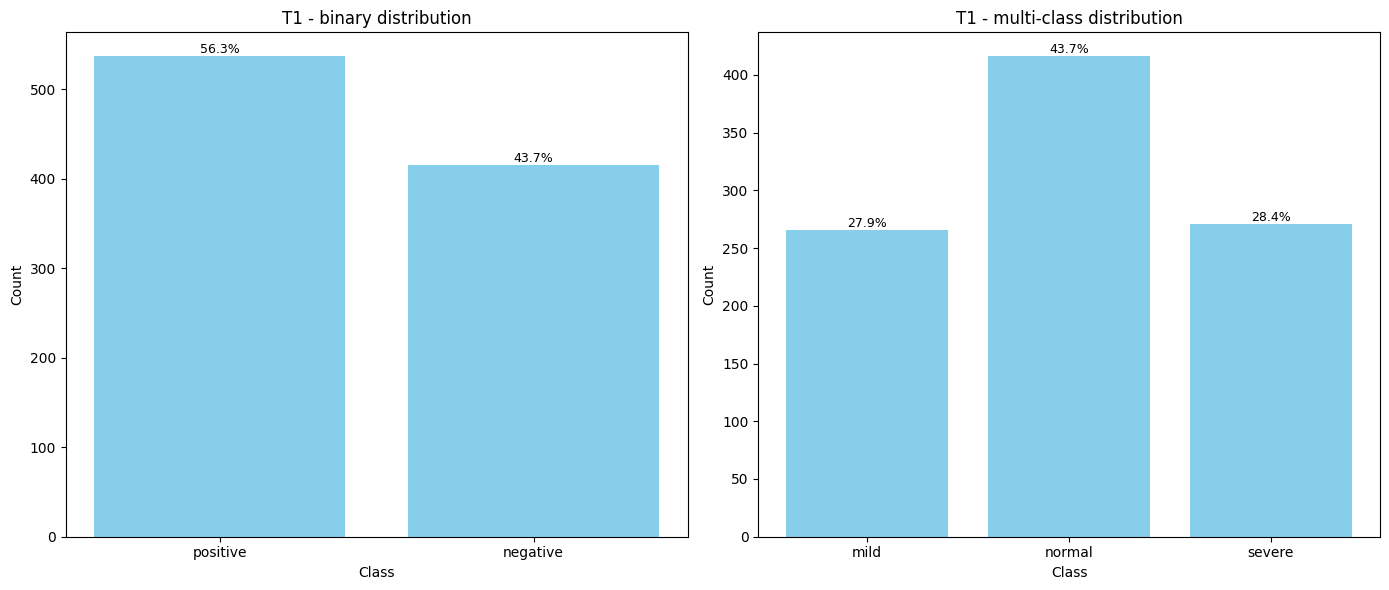

T1 - binary splits saved: Train=762, Val=95, Test=96				T1 - multi-class splits saved: Train=762, Val=95, Test=96				


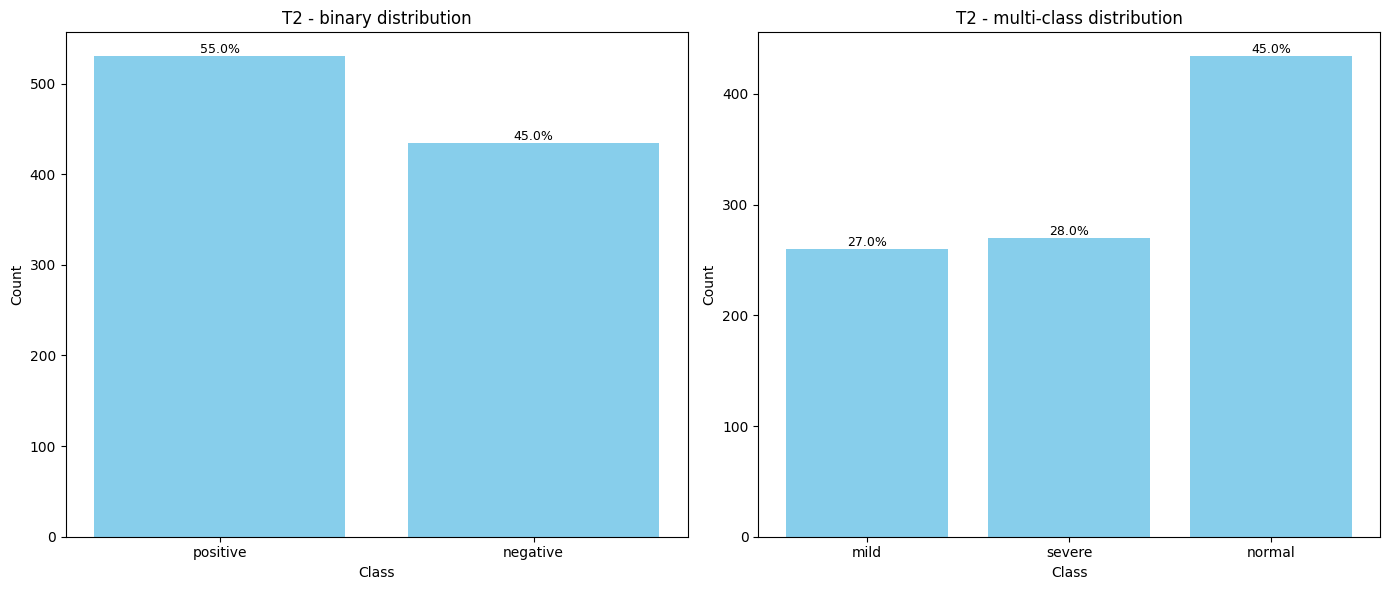

T2 - binary splits saved: Train=771, Val=96, Test=97				T2 - multi-class splits saved: Train=771, Val=96, Test=97				


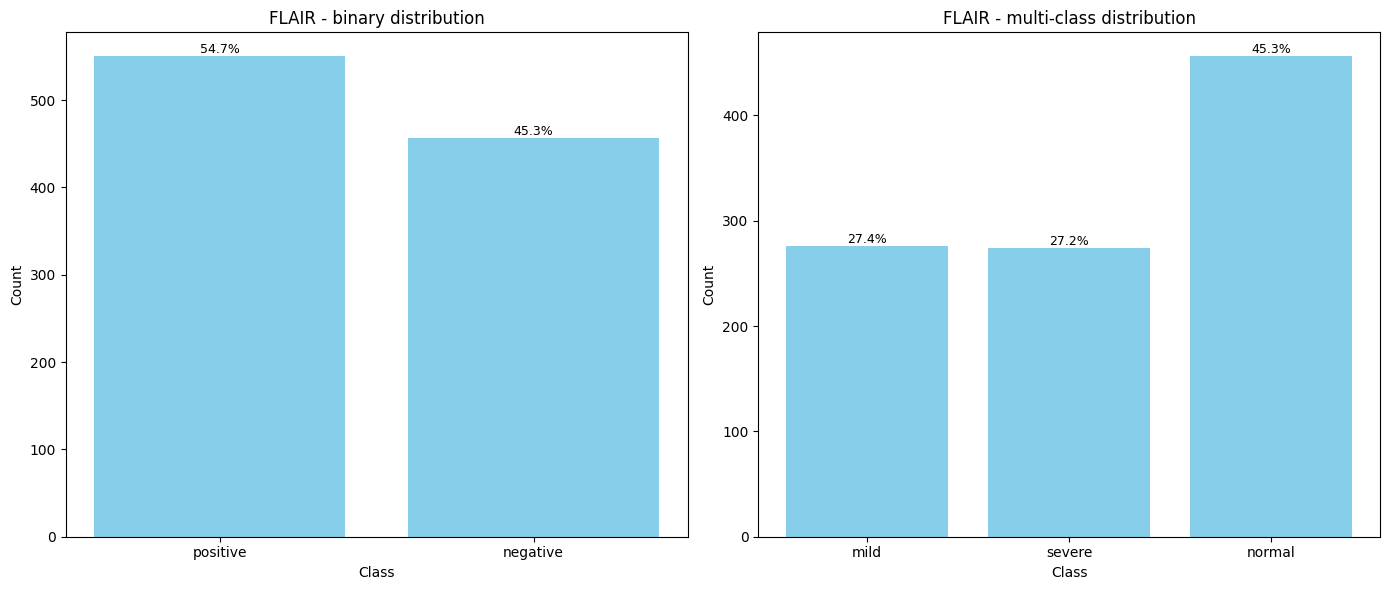

FLAIR - binary splits saved: Train=804, Val=101, Test=101				FLAIR - multi-class splits saved: Train=804, Val=101, Test=101				


In [1]:
%reload_ext autoreload
%autoreload 2

import os
import shutil
import re
from pathlib import Path
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from utils.constants import *

DATA_DIR = "dataset"
OUTPUT_DIR = "dataset-stratified"
MODALITIES = ["T1", "T2", "FLAIR"]
TASKS = ["binary", "multi-class"]
EXT = ".png"

pattern = re.compile(r"_EDSS(\d+(?:\.\d+)?)\.png")

def get_label(edss_val, task):
    for cls, (low, high) in CLASS_THRESHOLDS[task].items():
        if low <= edss_val < high:
            return cls
    return None


Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Get class distribution for each modality and task. Create new dataset with pre-defined stratified splits
for modality in MODALITIES:
    root_dir = os.path.join(DATA_DIR, modality)
    files = [f for f in os.listdir(root_dir) if os.path.splitext(f)[1] == EXT]

    task_data = {}
    task_label_counters = {}

    for task in TASKS:
        X, y = [], []
        label_counter = defaultdict(int)

        for fname in files:
            match = pattern.search(fname)
            if not match:
                continue
            edss_val = float(match.group(1))
            label = get_label(edss_val, task)

            if label is None:
                continue

            full_path = os.path.join(root_dir, fname)
            X.append(full_path)
            y.append(label)
            label_counter[label] += 1

        if not X:
            print(f"Skipping {modality}-{task} (no valid files found)")
            continue

        task_data[task] = (X, y)
        task_label_counters[task] = label_counter

    # Plot side-by-side class distributions for this modality
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for ax, task in zip(axes, TASKS):
        label_counter = task_label_counters.get(task, None)
        if not label_counter:
            ax.set_title(f"No data for {task}")
            continue

        labels = list(label_counter.keys())
        counts = list(label_counter.values())
        total = sum(counts)
        freqs = [count / total for count in counts]

        bars = ax.bar(labels, counts, color="skyblue")
        ax.set_title(f"{modality} - {task} distribution")
        ax.set_xlabel("Class")
        ax.set_ylabel("Count")

        for bar, freq in zip(bars, freqs):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f"{freq:.1%}",
                    ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

    # Stratified split and save files for each task separately
    for task in TASKS:
        if task not in task_data:
            continue

        X, y = task_data[task]

        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y,
            test_size=(1 - TRAIN_PERCENTAGE),
            random_state=RANDOM_SEED,
            stratify=y
        )

        val_ratio = VAL_PERCENTAGE / (VAL_PERCENTAGE + TEST_PERCENTAGE)
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=(1 - val_ratio),
            random_state=RANDOM_SEED,
            stratify=y_temp
        )

        for split_name, X_split, y_split in [
            ("train", X_train, y_train),
            ("val", X_val, y_val),
            ("test", X_test, y_test)
        ]:
            for src_path, label in zip(X_split, y_split):
                dst_dir = Path(OUTPUT_DIR) / modality / task / split_name
                dst_dir.mkdir(parents=True, exist_ok=True)
                dst_path = os.path.splitext(os.path.basename(src_path))[0] + f"_{label}_.png"
                shutil.copy(src_path, dst_dir / os.path.basename(dst_path))

        print(f"{modality} - {task} splits saved:"
              f" Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}", end="\t\t\t\t")
    print()


# Data Augmentation
This section is dedicated to augment data in the multiclass setting. Data will be saved to disk to avoid an ELT approach that would be more complicated and computationally demanding.

In [15]:
import tensorflow as tf
import tensorflow_models as tfm
import random
import os

T1 = 952
T2 = 964
FLAIR = 1006

DISTRIBUTIONS = {
    "normal": {
        "T1": int(T1 * 43.7 / 100),
        "T2": int(T2 * 45 / 100),
        "FLAIR": int(FLAIR * 45.3 / 100),
    },
    "mild": {
        "T1": int(T1 * 27.9 / 100),
        "T2": int(T2 * 27 / 100),
        "FLAIR": int(FLAIR * 27.4 / 100),
    },
    "severe": {
        "T1": int(T1 * 28.4 / 100),
        "T2": int(T2 * 28 / 100),
        "FLAIR": int(FLAIR * 27.2 / 100),
    }
}

BASE_PATH = "dataset-stratified"
MODALITIES = ["T1", "T2", "FLAIR"]
CLASSES = ["normal", "mild", "severe"]

def load_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=1)
    return image

def save_image(image, filepath):
    encoded = tf.io.encode_png(image)
    tf.io.write_file(filepath, encoded)

def augment_image_mri(image, min_degree: int = -15, max_degree: int = 15):
    """
    Applies anatomically plausible augmentation:
    - Small random rotation (-15 to +15 degrees)
    - Add subtle Gaussian noise
    """
    image = tf.cast(image, tf.float32) / 255.0
    image = tfm.vision.augment.rotate(image, float(random.randint(min_degree, max_degree)))

    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=50 / 255)
    image = image + noise

    image = tf.clip_by_value(image, 0.0, 1.0)
    image = tf.cast(image * 255.0, tf.uint8)
    return image

def augment_and_save(modality, cls, target_count):
    """
        Augment class to up until a certain target.

        Args:
            - modality: modality to augment.
            - cls: class to augment.
            - target_count: target to augment to.
    """
    class_path = os.path.join(BASE_PATH, modality, "multi-class", "train")
    files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.png') and f.split("_")[-2] == cls]

    current_count = len(files)
    if current_count >= target_count:
        print(f"{cls} {modality}: {current_count} samples (>= target {target_count}), skipping augmentation.")
        return

    needed = target_count - current_count
    print(f"Augmenting {cls} - {modality}: need {needed} samples (from {current_count})")

    idx = 0
    while needed > 0:
        image = load_image(files[idx % current_count])
        augmented_image = augment_image_mri(image, min_degree=-30, max_degree=30)

        aug_filename = f"aug_{idx}_{os.path.basename(files[idx % current_count])}"
        save_path = os.path.join(class_path, aug_filename)
        save_image(augmented_image, save_path)

        needed -= 1
        idx += 1

for modality in MODALITIES:
    normal_count = DISTRIBUTIONS["normal"][modality]
    for cls in ["mild", "severe"]:
        augment_and_save(modality, cls, normal_count)

print("Augmentation complete.")


213
Augmenting mild - T1: need 203 samples (from 213)
217
Augmenting severe - T1: need 199 samples (from 217)
208
Augmenting mild - T2: need 225 samples (from 208)
216
Augmenting severe - T2: need 217 samples (from 216)
221
Augmenting mild - FLAIR: need 234 samples (from 221)
219
Augmenting severe - FLAIR: need 236 samples (from 219)
Augmentation complete.


In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt

encoded = tf.io.read_file("dataset-stratified/T1/multi-class/train/1_T1_slice12_EDSS3_mild_.png")
image = tf.io.decode_png(encoded, channels=1)

augmented = augment_image_mri(image, min_degree=-30, max_degree=-30)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].axis("off")
axes[0].set_title("Original")
axes[0].imshow(image)
axes[1].axis("off")
axes[1].set_title("Augmented")
axes[1].imshow(augmented)